In [24]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

import matplotlib.pyplot as plt

In [25]:
# Setup plot defaultrialsrialsrialss
import matplotlib.pyplot as plt
import seaborn as sns

# Reset styling to default
plt.rcdefaults()
# Grid on
plt.rcParams['axes.grid'] = True
# Top and right axis spines off
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Title 18 x y labels 16 ticks 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig_w=6
fig_h=6
plt.rcParams['figure.figsize'] = (fig_w,fig_h )
# Make axis equal
#plt.rcParams['axes.axisbelow'] = True 


plt.rcParams['grid.color'] = '0.8'# Grid color

# Set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#043908', '#ff7f0e', '#9467bd', '#d62728', '#364704', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
# Set default grid settings
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['font.family'] = 'sans-serif'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 70

In [26]:
import pandas as pd
#load data
dataName="_auditoryDurEst_2025-04-24_14h30.44.137.csv"
"_auditoryDurEst_2025-04-24_14h12.55.479.csv"
"lc_bimodalDurEst_2025-04-16_17h45.41.209.csv"


"ek_bimodalDurEst_2025-04-12_18h52.18.703.csv"
"ydsontest_bimodalDurEst_2025-04-19_21h51.49.154.csv"
"ydsontest_bimodalDurEst_2025-04-19_21h51.49.154.csv"
"yd_bimodalDurEst_2025-04-19_21h01.18.649.csv"
"oy_bimodalDurEst_2025-04-17_19h32.55.390.csv"
"lc_bimodalDurEst_2025-04-16_17h45.41.209.csv"
"oy_bimodalDurEst_2025-04-17_19h32.55.390.csv"
"oy_bimodalDurEst_2025-04-18_12h02.49.051.csv"
"oy_bimodalDurEst_2025-04-17_19h32.55.390.csv"
"lc_bimodalDurEst_2025-04-16_17h45.41.209.csv"
"lc_auditoryDurEst_2025-04-16_17h12.08.117.csv"
"lc_bimodalDurEst_2025-04-16_17h45.41.209.csv"
#"ek_bimodalDurEst_2025-04-14_17h29.23.677.csv"
"ek_bimodalDurEst_2025-04-12_18h52.18.703.csv"
"oy_bimodalDurEst_2025-04-14_15h32.16.985.csv"

"ek_bimodalDurEst_2025-04-14_16h04.35.247.csv"
"oy_bimodalDurEst_2025-04-14_15h32.16.985.csv"
#"oy_bimodalDurEst_2025-04-14_15h32.16.985.csv"
#"ek_bimodalDurEst_2025-04-12_18h52.18.703.csv"
#"oy_bimodalDurEst_2025-03-27_14h36.59.505.csv"
"oy_bimodalDurEst_2025-03-27_13h58.22.519.csv"
#"_bimodal_audioVisual_durEst_2025-03-26_14h12.17.579 - Copy.csv"
#"oy_bimodal_audioVisual_durEst_2025-03-26_19h12.46.806.csv"
"_bimodal_audioVisual_durEst_2025-03-26_14h12.17.579 - Copy.csv"
#"_bimodal_audioVisual_durEst_2025-03-26_11h17.15.049.csv"
#"_bimodal_audioVisual_durEst_2025-03-25_19h15.28.386.csv"
"_bimodal_audioVisual_durEst_2025-03-20_18h29.39.932.csv"

data = pd.read_csv("dataBimodal/"+dataName)
data[:4]
data

#remove if audNoise is 0
data = data[data['audNoise'] != 0]

In [27]:
noiseVar="audNoise"

In [28]:
from scipy.stats import norm
from scipy.optimize import minimize
data

,Unnamed: 0,standardDur,audNoise,order,preDur,postDur,isiDur,trial_num,totalDur,delta_dur_percents,...,stair_is_reversal,response_keys,conflictDur,recordedOnsetVisualTest,recordedOffsetVisualTest,recordedDurVisualTest,recordedOnsetVisualStandard,recordedOffsetVisualStandard,recordedDurVisualStandard,modalityPostCue
0,0,0.50267,1.2,1,0.34349,0.43565,0.40214,0,1.85989,-0.650,...,False,right,0.0,0.3488,0.5238,0.1751,0.9238,1.4245,0.5007,A
1,1,0.50267,0.1,2,0.20945,0.44403,0.65347,1,1.98556,-0.650,...,False,left,0.0,1.3635,1.5395,0.1760,0.2137,0.7135,0.4998,V
2,2,0.50267,1.2,2,0.24296,0.21782,0.82103,2,1.96042,-0.650,...,False,left,0.0,1.5605,1.7352,0.1746,0.2438,0.7437,0.4998,A
3,3,0.50267,0.1,1,0.33512,0.41889,0.73725,3,2.04420,-0.900,...,False,right,0.0,0.3391,0.3890,0.0500,1.1223,1.6225,0.5001,V
4,4,0.50267,0.1,2,0.28485,0.22620,0.57807,4,1.76773,-0.650,...,False,left,0.0,1.3654,1.5405,0.1751,0.2902,0.7917,0.5016,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,303,0.50267,0.1,1,0.31836,0.43565,0.65347,303,2.30391,-0.214,...,True,right,0.0,0.3263,0.7178,0.3915,1.3681,1.8671,0.4991,A
304,304,0.50267,1.2,2,0.42727,0.36025,0.41052,304,1.98556,-0.430,...,False,left,0.0,1.3407,1.6242,0.2835,0.4326,0.9326,0.5000,A
305,305,0.50267,0.1,1,0.28485,0.31836,0.69536,305,2.58038,0.566,...,True,right,0.0,0.2944,1.0683,0.7740,1.7598,2.2609,0.5011,A
306,306,0.50267,1.2,2,0.30998,0.20945,0.87968,306,2.31230,-0.178,...,False,left,0.0,1.6905,2.0994,0.4089,0.3154,0.8156,0.5002,V


# Define Psychometric Function and Optimization

In [29]:

def psychometric_function(intensities, lapse_rate, mu, sigma):
    # Cumulative distribution function with mean mu and standard deviation sigma
    cdf = norm.cdf(intensities, loc=mu, scale=sigma) 
    # take into account of lapse rate and return the probability of choosing test
    return lapse_rate * 0.5 + (1 - lapse_rate) * cdf 

def derivative_psychometric_function(intensities, lapse_rate, mu, sigma):
    #F'(x) = (1-lambda)*(1(/sqrt(2*pi)sigma)exp((x-mu)^2/sigma^2)

    return (1 - lapse_rate) * (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-((intensities - mu) ** 2) / (2 * sigma ** 2))    

# Negative log-likelihood
def negative_log_likelihood(params, delta_dur, chose_test, totalResp, fixedLapse=None,fixedSigma=None):
    if fixedLapse== None and fixedSigma== None:
        lambda_, mu, sigma = params # Unpack parameters
    elif  fixedLapse is not None and fixedSigma== None:
        lambda_ = fixedLapse
        mu, sigma = params
    elif fixedSigma != None and fixedLapse != None:
        mu=params
        sigma = fixedSigma
        lambda_=fixedLapse
    p = psychometric_function(delta_dur, lambda_, mu, sigma) # Compute probability of choosing test
    epsilon = 1e-9 # Add a small number to avoid log(0) when calculating the log-likelihood
    p = np.clip(p, epsilon, 1 - epsilon) # Clip p to avoid log(0) and log(1)
    # Compute the negative log-likelihood
    log_likelihood = np.sum(chose_test * np.log(p) + (totalResp - chose_test) * np.log(1 - p))
    return -log_likelihood

# Fit psychometric function
def fit_psychometric_function(levels,nResp, totalResp,init_guesses=[0,0,0], fixedLapse=None,fixedSigma=None):
    # then fits the psychometric function
    # order is lambda mu sigma
    #initial_guess = [0, -0.2, 0.05]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0, 0.2), (-0.4, +0.4), (0.01, 1)]  # Reasonable bounds
    init_guesses=init_guesses
    
    # Lambda and Sigma fixed Optimize for MU
    if fixedLapse is not None and fixedSigma is not None:
        # If both lapse rate and sigma are fixed, we only optimize mu
        bounds = [(-0.2, +0.2)]  # Only mu is optimized
        init_guesses = [init_guesses[1]]  # Start with the initial guess for mu
   
    # Lambda is fixed, we OPTIMIZE FOR MU AND SIGMA
    elif fixedLapse!= None and fixedSigma== None:
        # If only lapse rate is fixed, we optimize mu and sigma
        bounds = [ (-0.2, +0.2), (0.02, 1)]  # Lapse rate fixed, optimize mu and sigma
        init_guesses = init_guesses[1:]  # Start with the initial guesses for mu and sigma
    
    #  Sigma is fixed, we OPTIMIZE LAMBDA and MU
    elif fixedSigma!= None and fixedLapse== None: 
        # If only sigma is fixed, we optimize lambda and mu
        bounds = [(0, 0.2), (-0.2, +0.2)]  # Lapse rate and mu are optimized
        init_guesses = [init_guesses[0], init_guesses[1]]  # Start with the initial guesses for lambda and mu


  #  bounds=[[0,-0.8,0.05],[0.06,0.8,1]]
    # fitting is done here
    result = minimize(
        negative_log_likelihood, x0=init_guesses, 
        args=(levels, nResp, totalResp,fixedLapse, fixedSigma),  # Pass the data and fixed parameters
        bounds=bounds,
        method='Nelder-Mead'
    )
    # returns the fitted parameters lambda, mu, sigma
    return result.x

# Compute sigma from slope
def compute_sigma_from_slope(slope, lapse_rate=0.02):
    sigma = (1 - lapse_rate) / (np.sqrt(2 * np.pi) * slope)*np.exp(-0.5)
    return sigma


def fitMultipleStartingPoints(levels, nResp, totalResp, multipleInitGuesses, fixedLapse=None,fixedSigma=None):
    best_fit = None
    best_nll = float('inf')  # Initialize with infinity

    for init_guesses in multipleInitGuesses:
        try:
            fit = fit_psychometric_function(levels, nResp, totalResp, init_guesses, fixedLapse, fixedSigma)
            nll = negative_log_likelihood(fit, levels, nResp, totalResp,fixedLapse,fixedSigma)

            if nll < best_nll:
                best_nll = nll
                best_fit = fit
        except Exception as e:
            print(f"Error fitting with initial guesses {init_guesses}: {e}")

    return best_fit



#  Raw psychometric

In [30]:
def rawNegLogLike(params, level, response):
    # Unpack parameters
    lapse_rate, mu, sigma = params
    # Compute the probability of choosing test
    p = psychometric_function(level, lapse_rate, mu, sigma)
    # Add a small number to avoid log(0)
    epsilon = 1e-9
    p = np.clip(p, epsilon, 1 - epsilon)
    # Compute the negative log-likelihood
    log_likelihood = np.sum(response * np.log(p) + (1 - response) * np.log(1 - p))
    return -log_likelihood

# Fit psychometric function
def fitPsychometricRaw(levels, response,init_guesses=[0,0,0]):
    #initial_guess = [0, -0.2, 0.05]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0, 0.2), (-0.4, +0.4), (0.05, 1)]  # Reasonable bounds
  #  bounds=[[0,-0.8,0.05],[0.06,0.8,1]]
    # fitting is done here
    result = minimize(
        rawNegLogLike, x0=init_guesses, 
        args=(levels, response),
        bounds=bounds,
        method='LBFGS-B'
    )
    # returns the fitted parameters lambda, mu, sigma
    return result.x


# Group data

In [31]:
# Define columns for chosing test or standard
data['chose_test'] = (data['responses'] == data['order']).astype(int)
data['chose_standard'] = (data['responses'] != data['order']).astype(int)
try:
    print(data[noiseVar]>1)
except:
    data[noiseVar]=1

data['standard_dur']=data['standardDur']

def groupByChooseTest(x):
    grouped = x.groupby(['delta_dur_percents', noiseVar, 'standard_dur']).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count'),
        num_of_chose_standard=('chose_standard', 'sum')
    ).reset_index()
    grouped['p_choose_test'] = grouped['num_of_chose_test'] / grouped['total_responses']

    return grouped

def groupByStandardDur(x):
    grouped = x.groupby(['delta_dur_percents', noiseVar, 'standard_dur']).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count'),
        num_of_chose_standard=('chose_standard', 'sum')
    ).reset_index()
    grouped['pChooseStandard'] = grouped['num_of_chose_standard'] / grouped['total_responses']

    return grouped

grouped=groupByChooseTest(data)
# p_choose_test
#sort the group
grouped = grouped.sort_values([ 'standard_dur'])

0       True
1      False
2       True
3      False
4      False
       ...  
303    False
304     True
305    False
306     True
307    False
Name: audNoise, Length: 308, dtype: bool


# Estimate initial parameters

In [32]:
from scipy.stats import linregress
def estimate_initial_guesses(levels,chooseTest,totalResp, max_sigma_ratio=0.2):
    """
    Estimate initial guesses for lambda, mu, and sigma with slope adjustment and sigma regularization.
    """
    intensities = levels
    chose_test = chooseTest
    total_resp = totalResp
    
    # Compute proportion of "chose test"
    proportions = chose_test / total_resp
    
    # Perform linear regression to estimate slope and intercept
    slope, intercept, _, _, _ = linregress(intensities, proportions)
    mu_guess = (0.5 - intercept) / slope

    #print(slope, intercept)
    lapse_rate_guess= 0.03  # 5% as a reasonable guess
    sigma_guess= compute_sigma_from_slope(slope,lapse_rate_guess)-0.1

    # Regularize sigma to avoid overestimation
    intensity_range = np.abs(max(intensities)) - np.abs(min(intensities))
    max_sigma = intensity_range * max_sigma_ratio
    #sigma_guess = min(sigma_guess, max_sigma)
    #sigma_guess=sigma_guess/3
    
    return [lapse_rate_guess, mu_guess, sigma_guess]
estimate_initial_guesses(grouped['delta_dur_percents'],grouped['num_of_chose_test'],grouped['total_responses'])

def estimateInitialGuessesRaw(levels,responses,maxSigmaRatio=0.2):
    """
    Estimate initial guesses for lambda, mu, and sigma with slope adjustment and sigma regularization.
    """
    # Compute proportion of "chose test"
    proportions = responses / levels
    
    # Perform linear regression to estimate slope and intercept
    slope, intercept, _, _, _ = linregress(levels, proportions)
    mu_guess = (0.5 - intercept) / slope

    #print(slope, intercept)
    lapse_rate_guess= 0.03  # 5% as a reasonable guess
    sigma_guess= compute_sigma_from_slope(slope,lapse_rate_guess)-0.1

    # Regularize sigma to avoid overestimation
    intensity_range = np.abs(max(levels)) - np.abs(min(levels))
    max_sigma = intensity_range * maxSigmaRatio
    sigma_guess = min(sigma_guess, max_sigma)
    #sigma_guess=sigma_guess/3
    
    return [lapse_rate_guess, mu_guess, sigma_guess]


# 1 by 1 Psychometric Function fitting

In [33]:
conflictLeves=sorted(data['conflictDur'].unique())
standardDurLevels=sorted(data['standardDur'].unique())
noiseLevels=sorted(data[noiseVar].unique())
print(f"Standard duration levels: {standardDurLevels}, Conflict levels: {conflictLeves}, Noise levels: {noiseLevels}")

Standard duration levels: [0.50267], Conflict levels: [0.0], Noise levels: [0.1, 1.2]


# Aggregate data and fit psychometric function

Standard (Visual)duration: 0.50267, Noise level: 0.1, Conflict level: 0.0, Fitted parameters: [0.09506962 0.09810779 0.29434359]
Standard (Visual)duration: 0.50267, Noise level: 1.2, Conflict level: 0.0, Fitted parameters: [0.2        0.05471637 0.51225615]


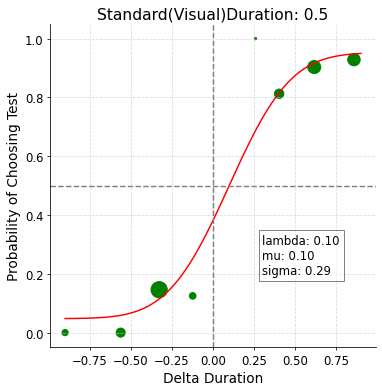

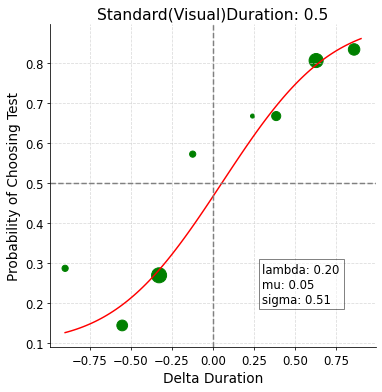

In [34]:
for i, standardLevel in enumerate(standardDurLevels):
    for j, noiseLevel in enumerate(noiseLevels):
        for k, conflictLevel in enumerate(conflictLeves):        
            #filter data
            df=data[data['conflictDur']==conflictLevel]
            df= df[df["standardDur"]==standardLevel]
            df=df[df[noiseVar]==noiseLevel]

            grouped=groupByChooseTest(df)
            # p_choose_test
            levels=grouped['delta_dur_percents'].values
            responses=grouped['num_of_chose_test'].values
            totalResponses=grouped['total_responses'].values
            # estimate initial guesses
            initial_guesses = estimate_initial_guesses(levels, responses, totalResponses)
            # fit psychometric function
            fitted_params = fit_psychometric_function(levels, responses, totalResponses,initial_guesses)
            # print fitted parameters
            print(f"Standard (Visual)duration: {standardLevel}, Noise level: {noiseLevel}, Conflict level: {conflictLevel}, Fitted parameters: {fitted_params}")

            # plot psychometric function
            plt.figure()
            #plt.scatter(levels, responses/totalResponses, label='Data', color='blue')
            x = np.linspace(-0.9, 0.9, 100)
            y = psychometric_function(x, *fitted_params)
            plt.plot(x, y, label='Psychometric Function', color='red')
            plt.axvline(x=0, color='gray', linestyle='--',)
            plt.axhline(y=0.5, color='gray', linestyle='--')
            plt.xlabel('Delta Duration')
            plt.ylabel('Probability of Choosing Test')
            plt.title(f'Standard(Visual)Duration: {round(standardLevel,2)}')
            # add fitted parameters to the plot
            plt.text(0.3, 0.2, f'lambda: {fitted_params[0]:.2f}\nmu: {fitted_params[1]:.2f}\nsigma: {fitted_params[2]:.2f}', fontsize=12, 
                     bbox=dict(facecolor='white', alpha=0.5))
            
            

            # Bin using pd.cut
            binSize=8 # number of bins
            grouped['bin'] = pd.cut(grouped['delta_dur_percents'], bins=binSize,
                                    labels=False, include_lowest=True,retbins=False)
            #calculate means and sums for each bin
            binGroup=grouped.groupby('bin').agg(
                mean_delta_dur=('delta_dur_percents', 'mean'),
                sum_num_of_chose_test=('num_of_chose_test', 'sum'),
                sum_total_responses=('total_responses', 'sum')
            ).reset_index()
            #total responses for normalization of marker size
            totalResponsesSum=grouped['total_responses'].sum()
            #calculate proportions
            binGroup['pChooseTest'] = binGroup['sum_num_of_chose_test'] / binGroup['sum_total_responses']
            #plot binned data
            plt.scatter(binGroup['mean_delta_dur'], binGroup['pChooseTest'], label='Binned Data', color='green'
                        ,s=binGroup['sum_total_responses']/totalResponsesSum*900)
            


# unified Model fit


In [35]:
aggregatedData=groupByChooseTest(data)
aggregatedData

,delta_dur_percents,audNoise,standard_dur,num_of_chose_test,total_responses,num_of_chose_standard,p_choose_test
0,-0.900,0.1,0.50267,0,7,7,0.000000
1,-0.900,1.2,0.50267,2,7,5,0.285714
2,-0.650,0.1,0.50267,0,2,2,0.000000
3,-0.650,1.2,0.50267,0,3,3,0.000000
4,-0.610,0.1,0.50267,0,2,2,0.000000
...,...,...,...,...,...,...,...
95,0.926,1.2,0.50267,2,2,0,1.000000
96,0.950,0.1,0.50267,2,2,0,1.000000
97,0.950,1.2,0.50267,1,1,0,1.000000
98,0.962,0.1,0.50267,2,2,0,1.000000


In [36]:
nLambda=1
uniqueNoiseLevels=sorted(data[noiseVar].unique())

nSigma=len(uniqueNoiseLevels)
nMu=nSigma*nLambda

In [37]:
def negLLMultiParams(params, levels, responses, totalResp,audNoises):
    nll=0
    lambda_,muA,muB,sigmaA,sigmaB = params
    
    uniqueAudNoise = np.unique(audNoises)
    for i in range(len(audNoises)):
        currNoise=audNoises[i]
        currResponse=responses[i]
        currLevel=levels[i]
        currTotalResp=totalResp[i]
        if audNoises[i]==uniqueAudNoise[0]:
            sigma=sigmaA
            mu=muA
        elif audNoises[i]==uniqueAudNoise[1]:
            sigma=sigmaB
            mu=muB
        # Compute the probability of choosing test
        p = psychometric_function(currLevel, lambda_, mu, sigma)
        # Add a small number to avoid log(0)
        epsilon = 1e-9
        p = np.clip(p, epsilon, 1 - epsilon)
        
        # Add to the the negative log-likelihood
        nll += -1 * (currResponse * np.log(p) + (currTotalResp - currResponse) * np.log(1 - p))

    return nll

def fitMultiParams(levels, responses, totalResp, audNoises, init_guesses):
    init_guesses= [init_guesses[0]]*1+[init_guesses[1]]*nSigma+[init_guesses[2]]*nMu
    #initial_guess = [0, -0.2, 0.05]  # Initial guess for [lambda, mu, sigma]
    #bounds = [(0, 0.2), (-0.4, +0.4), (0.01, 1)]  # Reasonable bounds
    bounds = [(0, 0.2)] + [(-0.6, +0.6)]*nMu + [(0.01, 1)]*nSigma
    if len(levels) == 0 or len(responses) == 0 or len(totalResp) == 0 or len(audNoises) == 0:
        raise ValueError("Input data for fitting is empty. Please check the input data.")
    # fitting is done here
    result = minimize(
        negLLMultiParams, x0=init_guesses, 
        args=(levels, responses, totalResp,audNoises),  # Pass the data and fixed parameters
        bounds=bounds,
        method='L-BFGS-B'
    )
    # returns the fitted parameters lambda, muA, muB sigmaA sigmaB
    return result.x

# Fit the data using the multi-parameter fitting function
from tqdm import tqdm
# Prepare data for fitting
def fitMultipleStartingPoints(levels, nResp, totalResp, noiseLevels, multipleInitGuesses):
    best_fit = None
    best_nll = float('inf')  # Initialize with infinity
    for i in tqdm(range(len(multipleInitGuesses)), desc="Fitting multiple starting points"):
        fit = fitMultiParams(levels, nResp, totalResp, noiseLevels, multipleInitGuesses[i])
        nll = negLLMultiParams(fit, levels, nResp, totalResp, noiseLevels)

        if nll < best_nll:
            best_nll = nll
            best_fit = fit

    return best_fit




# Prepare data for s
levels = aggregatedData['delta_dur_percents']
responses = aggregatedData['num_of_chose_test']
totalResponses = aggregatedData['total_responses']
audNoises = aggregatedData[noiseVar]



# Estimate initial guesses for the parameters
initial_guesses = [0.01, 0.0, 0.0, 0.01, 0.01]  # [lambda, muA, muB, sigmaA, sigmaB]
multipleInitGuesses = []
for i in range(10):
    initial_guesses = estimate_initial_guesses(levels, responses, totalResponses)
    multipleInitGuesses.append(initial_guesses)

nStart=2
initLambdas=np.linspace(0.01, 0.06, nStart)
initMus=np.linspace(-0.5, 0.5, nStart)
initSigmas=np.linspace(0.01, 0.5, nStart)
multipleInitGuesses = []
for i, initLambda in enumerate(initLambdas):
    for j, initMu in enumerate(initMus):
        for k, initSigma in enumerate(initSigmas):
            multipleInitGuesses.append([initLambda, initMu, initSigma])




# Fit the data using the multi-parameter fitting function
fitted_params = fitMultipleStartingPoints(levels, responses, totalResponses, audNoises, multipleInitGuesses)

# Print the fitted parameters
print(f"Fitted parameters: Lambda: {fitted_params[0]:.3f}, MuA: {fitted_params[1]:.3f}, MuB: {fitted_params[2]:.3f}, SigmaA: {fitted_params[3]:.3f}, SigmaB: {fitted_params[4]:.3f}")



Fitting multiple starting points: 100%|██████████| 8/8 [00:03<00:00,  2.28it/s]

Fitted parameters: Lambda: 0.112, MuA: 0.094, MuB: 0.058, SigmaA: 0.279, SigmaB: 0.615


In [38]:
def binAndPlot(data, intensityVar,probVar,nResp, bin_method='cut', bins=10, bin_range=None, plot=True,color="blue"):
	if bin_method == 'cut':
		data['bin'] = pd.cut(data[intensityVar], bins=bins, labels=False, include_lowest=True, retbins=False)
	elif bin_method == 'manual':
		data['bin'] = np.digitize(data[intensityVar], bins=bin_range) - 1
	
	grouped = data.groupby('bin').agg(
		x_mean=(intensityVar, 'mean'),
		y_mean=(probVar, 'mean'),
		total_resp=(nResp, 'sum')
	)

	if plot:
		plt.scatter(grouped['x_mean'], grouped['y_mean'], s=grouped['total_resp']/data[nResp].sum()*900, color=color)

	
#binAndPlot(aggregatedData, 'delta_dur_percents', 'p_choose_test', 'total_responses', bin_method='cut', bins=8, bin_range=None, plot=True, color="blue")

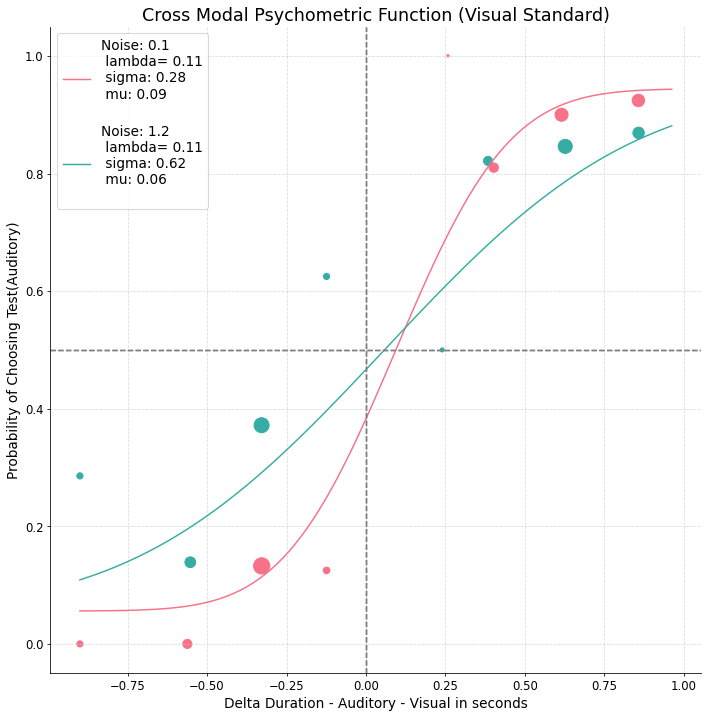

In [43]:
# plot the data 
m=0
plt.figure(figsize=(fig_w*2,fig_h*2))
for i, noiseLevel in enumerate(noiseLevels):
    for j, conflictLevel in enumerate(conflictLeves):        
        #filter data
        df=data[data['conflictDur']==conflictLevel]
        df= df[df[noiseVar]==noiseLevel]
        #group df
        # select levels
        levels=df['delta_dur_percents'].values
        responses=df['chose_test'].values
        lambda_=fitted_params[0]
        mu=fitted_params[1+m]
        sigma=fitted_params[3+m]
        df=groupByChooseTest(df)
        color=sns.color_palette("husl", len(noiseLevels))[m]
        # plot psychometric function
        binAndPlot(df, 'delta_dur_percents', 'p_choose_test', 'total_responses', bin_method='cut', bins=8, bin_range=None, plot=True, color=color)
        minLevel=min(data['delta_dur_percents'])
        maxLevel=max(data['delta_dur_percents'])
        x = np.linspace(minLevel, maxLevel, 100)
        y = psychometric_function(x, fitted_params[0], mu, sigma)
        plt.plot(x, y, color=color, label=f'Noise: {noiseLevel}\n lambda= {round(lambda_,2)}\n sigma: {sigma:.2f}\n mu: {mu:.2f}\n')
        plt.axvline(x=0, color='gray', linestyle='--',)
        plt.axhline(y=0.5, color='gray', linestyle='--')
        plt.xlabel('Delta Duration - Auditory - Visual in seconds')
        plt.ylabel('Probability of Choosing Test(Auditory)')
        # general title
        plt.title("Cross Modal Psychometric Function (Visual Standard)" ,fontsize=18)
        #plt.title(f'Noise Level: {noiseLevel}, Conflict Level: {conflictLevel}')
        # add fitted parameters to the plot
        # plt.text(0.3, 0.2, f'lambda: {fitted_params[0]:.2f}\nmu: {mu:.2f}\nsigma: {sigma:.2f}', fontsize=12, 
        #          bbox=dict(facecolor='white', alpha=0.5))
        
        plt.legend(fontsize=14)    
    m+=1



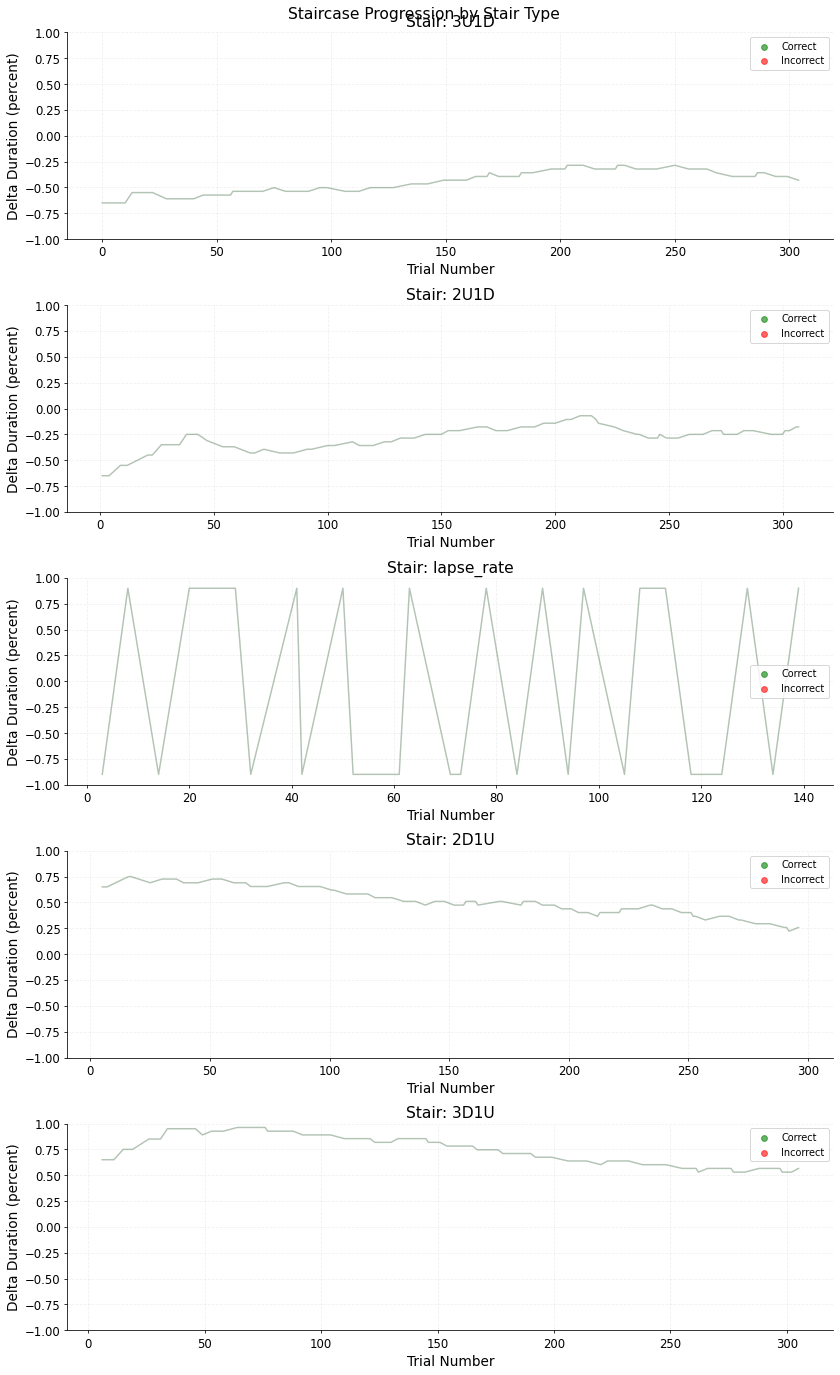

In [40]:
unique_stairs=data['current_stair'].unique()
# Create subplots
n_stairs = len(unique_stairs)
fig, axes = plt.subplots(n_stairs, 1, figsize=(12, 4*n_stairs))
fig.suptitle('Staircase Progression by Stair Type', fontsize=16)

for idx, stair in enumerate(unique_stairs):
    # Filter data for current stair
    stair_data = data[data['current_stair'] == stair]
    
    # Plot correct and incorrect trials
    correct_trials = stair_data[stair_data['is_correct'] == 'True']
    incorrect_trials = stair_data[stair_data['is_correct'] == 'False']
    
    # Plot correct trials in green
    axes[idx].scatter(correct_trials['trial_num'], 
                     correct_trials['delta_dur_percents'],
                     c='green', label='Correct', alpha=0.6)
    
    # Plot incorrect trials in red
    axes[idx].scatter(incorrect_trials['trial_num'],
                     incorrect_trials['delta_dur_percents'], 
                     c='red', label='Incorrect', alpha=0.6)
    
    # Connect points with a line
    axes[idx].plot(stair_data['trial_num'], 
                  stair_data['delta_dur_percents'],
                  alpha=0.3)
    
    # Customize subplot
    axes[idx].set_xlabel('Trial Number')
    axes[idx].set_ylabel('Delta Duration (percent)')
    axes[idx].set_title(f'Stair: {stair}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    # set y limit
    axes[idx].set_ylim(-1, 1)

plt.tight_layout()


Text(0.5, 1.05, 'Order Bias Analysis')

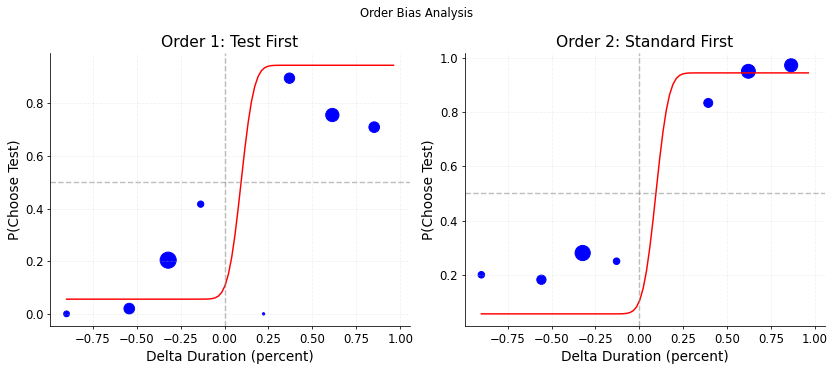

In [41]:
# Create figure for order bias analysis
plt.figure(figsize=(12, 5))

# Create subplots for each order (1: test first, 2: standard first)
orders = [1, 2]
for i, order in enumerate(orders, 1):
    plt.subplot(1, 2, i)
    
    # Filter data for current order
    order_data = data[data['order'] == order]
    grouped_order = groupByChooseTest(order_data)
    
    # Plot binned data points
    binAndPlot(grouped_order, 'delta_dur_percents', 'p_choose_test', 'total_responses', 
              bin_method='cut', bins=8, bin_range=None, plot=True, color='blue')
    
    # Plot psychometric function
    x = np.linspace(min(data['delta_dur_percents']), max(data['delta_dur_percents']), 100)
    y = psychometric_function(x, fitted_params[0], fitted_params[1], fitted_params[2])
    plt.plot(x, y, 'r-', label='Fitted Function')
    
    # Add reference lines
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    
    # Customize plot
    plt.xlabel('Delta Duration (percent)')
    plt.ylabel('P(Choose Test)')
    plt.title(f'Order {order}: {"Test First" if order==1 else "Standard First"}')
    plt.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.suptitle('Order Bias Analysis', y=1.05)

# Parametric bootstraping  for the confidence intervals

In [42]:
break the code
grouped['total_responses'].values

SyntaxError: invalid syntax (2861491427.py, line 1)

In [ ]:
totalResponses

0     7
1     7
2     2
3     1
4     1
     ..
74    2
75    1
76    2
77    7
78    7
Name: total_responses, Length: 79, dtype: int64

In [ ]:
# prepare for multiple start of unut guesses
multipleInitGuesses = []
# 100 random multiple starts
nStarts = 5
initLambdas = np.linspace(0, 0.2, nStarts)  # Different initial guesses for lambda
initMus = np.linspace(-0.15, 0.15, nStarts)  # Different initial guesses for mu
initSigmas = np.linspace(0.05, 1, nStarts)  # Different initial guesses for sigma
for initLambda in initLambdas:
    for initMu in initMus:
        for initSigma in initSigmas:
            multipleInitGuesses.append([initLambda, initMu, initSigma])



In [ ]:
# prepare for multiple start of unut guesses
multipleInitGuesses50 = []
# 100 random multiple starts
nStarts = 30
initLambdas = np.linspace(0, 0.2, nStarts)  # Different initial guesses for lambda
initMus = np.linspace(-0.15, 0.15, nStarts)  # Different initial guesses for mu
initSigmas = np.linspace(0.05, 1, nStarts)  # Different initial guesses for sigma
for initLambda in initLambdas:
    for initMu in initMus:
        for initSigma in initSigmas:
            multipleInitGuesses50.append([initLambda, initMu, initSigma])



In [ ]:
fitted_params

array([ 0.02290367, -0.15451638,  0.28378094,  0.26742534,  0.5       ])

In [ ]:
levels=grouped['delta_dur_percents'].values
responses=grouped['num_of_chose_test'].values
totalResponses=grouped['total_responses'].values
fitted_params = fitMultipleStartingPoints(levels, responses, totalResponses, multipleInitGuesses50)

TypeError: fitMultipleStartingPoints() missing 1 required positional argument: 'multipleInitGuesses'

In [ ]:
def parametric_bootstrap(levels, responses, total_responses, fitted_params, n_bootstrap=1000):
    """
    Perform parametric bootstrapping to estimate confidence intervals for the fitted parameters.
    
    Parameters:
        levels (array): The stimulus levels (e.g., delta durations).
        responses (array): The number of "chose test" responses.
        total_responses (array): The total number of responses for each level.
        fitted_params (array): The fitted parameters [lambda, mu, sigma].
        n_bootstrap (int): The number of bootstrap samples.
    
    Returns:
        bootstrap_params (array): The bootstrap estimates of the parameters.
    """

    bootstrap_params = []
    for _ in range(n_bootstrap):
        # Generate synthetic data based on the fitted psychometric function
        p = psychometric_function(levels, *fitted_params) #  p is the probability of choosing test at each level
        # Simulate responses based on the fitted probabilities
        simulatedData = np.random.binomial(n=total_responses, p=p) # simulated responses for each level

        # Fit the psychometric function to the synthetic data
        initial_guesses = estimate_initial_guesses(levels, simulatedData, total_responses)
        bootstrap_fit = fit_psychometric_function(levels, simulatedData, total_responses, initial_guesses)
        bootstrap_params.append(bootstrap_fit)

    return np.array(bootstrap_params)

#
levels=grouped['delta_dur_percents'].values
responses=grouped['num_of_chose_test'].values
totalResponses=grouped['total_responses'].values
#initGuess=estimate_initial_guesses(levels, responses, totalResponses)

#fitted_params = fit_psychometric_function(grouped['delta_dur_percents'], grouped['num_of_chose_test'], grouped['total_responses'],initGuess)
# print(f"Fitted parameters: {fitted_params}")
# Example usage
n_bootstrap = 1000
bootstrap_results = parametric_bootstrap(levels, responses, totalResponses, fitted_params, n_bootstrap)

# Compute confidence intervals (e.g., 95%)
confidence_intervals = np.percentile(bootstrap_results, [2.5, 97.5], axis=0)
print(f"95% Confidence Intervals:\nLambda: {confidence_intervals[:, 0]}\nMu: {confidence_intervals[:, 1]}\nSigma: {confidence_intervals[:, 2]}")

# Plot the bootstrap results
plt.figure()
plt.hist(bootstrap_results[:, 0], bins=30, alpha=0.5, label='Lambda')
plt.hist(bootstrap_results[:, 1], bins=30, alpha=0.5, label='Mu')
plt.hist(bootstrap_results[:, 2], bins=30, alpha=0.5, label='Sigma')
plt.axvline(x=fitted_params[0], color='red', linestyle='--', label='Fitted Lambda')
plt.axvline(x=fitted_params[1], color='blue', linestyle='--', label='Fitted Mu')
plt.axvline(x=fitted_params[2], color='green', linestyle='--', label='Fitted Sigma')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution of Parameters')
plt.legend()
plt.show()


TypeError: psychometric_function() takes 4 positional arguments but 6 were given

# My Bootstrap

In [ ]:
# simulate bootstrap data

"""Code explanation:
After simply fitting raw data I generated a parametric bootstrap dataset and fitted the psychometric function to the bootstrap dataset.
I repeated this process 1000 times and stored the fitted parameters in a list.

## Algorithm for bootstrapping

1. Filter data based on specific “rise duration” and “standard duration”
2. Fit filtered data
3. Compute probablity ‘p’ of “chosing test” for each intensity using psychometric function and retrieved fitting parameters
4. Create a resampled data using binomial draws on probablity p with n_trials 
5. Re-fit the psychometric function with resampled data to get bootstrapped parameter fits
6. Repeat for desired number of bootstraps


"""

# Generate a single parametric bootstrap dataset
def generate_parametric_bootstrap(original_data):
    simulated_data = original_data.copy()
    lambda_, mu_, sigma_ = fit_psychometric_function(original_data)

    for idx, row in simulated_data.iterrows():
        x = row['delta_dur_percents']
        n_trials = row['total_responses']
        
        # Compute the probability of "chose test" using the psychometric function
        p = psychometric_function(x, lambda_, mu_, sigma_)
        
        # Simulate responses as binomial random draws
        simulated_responses = np.random.binomial(n=n_trials, p=p)
        simulated_data.at[idx, 'num_of_chose_test'] = simulated_responses
    
    return simulated_data

